# Multi-Armed Bandit (k-Armed Bandit)


## References

* https://en.wikipedia.org/wiki/Multi-armed_bandit

In [1]:
from datetime import timedelta, datetime, date
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Theory


* Iteratively Selects One of the multiple fixed choices
* These choices are called `arms` or `actions` or `levers`
* Property of each choice is partially known at the time of allocation but become better understood as the time passes.
    * Either we know it earlier (Partially)
    * or we'll know it with time
* these arms are `Independent`
* This algorithm works as `Best Arm Identification`
* Target here is to `Minimize Regret`
* Exploration $\leftrightarrow$ Exploitation

> Objective
>> `Minimize` the sum of rewards earned through a sequence of lever pulls.
>>
>> Each machines provides a random reward from a probability distribution specific to the machine(not known apriori)



## Example

* Lets say a player enters a casino to play slot machines.
* there are 10 machines, but not all machines have same reward (win %) per gamble.
* Now the player had 

## Actions/ Levers

In [2]:
class Levers:
    @staticmethod
    def lever_1(mu=10, sigma=5):
        return np.random.normal(mu, sigma)

    @staticmethod
    def lever_2(mu=8, sigma=3):
        return np.random.normal(mu, sigma)

    @staticmethod
    def lever_3(mu=5, sigma=25):
        return np.random.normal(mu, sigma)
    
levers = ["lever_1", "lever_2", "lever_3"]


In [3]:

def levers_cyclic_iter(levers):
    i = 0
    while True:
        if i >= len(levers):
            i = 0
        yield levers[i]
        i += 1


In [4]:

def random_choose_lever(levers):
    return np.random.choice(levers, size=None, replace=True, p=None)

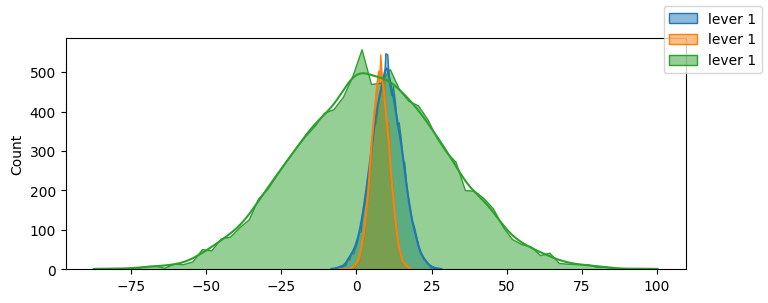

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

params = {
    "kde": True,
    "element": "poly",
    "label": "lever 1",
    "ax": ax,
}
sns.histplot([Levers.lever_1() for _ in range(10000)], **params)
sns.histplot([Levers.lever_2() for _ in range(10000)], **params)
sns.histplot([Levers.lever_3() for _ in range(10000)], **params)
fig.legend()
fig.show()

## Reward & Regret

In [6]:
def get_metrics(rewardsdf: pd.DataFrame):
    aggdf = rewardsdf.groupby(by=["lever", "decision"], as_index=False).agg(
        {"reward": ["count", "sum", "min", "max", "mean", "std"]}
    )
    max_reward = aggdf["reward"]["mean"].max()
    max_reward_lever_record = aggdf[aggdf["reward"]["mean"] == max_reward]
    chosen_lever = max_reward_lever_record["lever"].iloc[0]
    return aggdf, chosen_lever

In [7]:
def get_regret(aggdf: pd.DataFrame, n_iterations:int):
    max_reward = aggdf["reward"]["mean"].max()
    total_reward = aggdf["reward"]["sum"].sum()
    optimum_reward = max_reward * n_iterations
    regret = optimum_reward - total_reward
    print(f"""
    Optimum Reward  : {optimum_reward}
    Total Reward    : {total_reward} 
    Regret          : {regret}
    """)
    return optimum_reward, total_reward, regret

In [8]:
def plot_reward(rewarddf, x="ts"):
    rewarddf["decision-lever"] = rewarddf["decision"] + "-" + rewarddf["lever"]
    fig, ax = plt.subplots(2, 1, figsize=(15, 8))

    line_plot_params = {
        "alpha": 0.6,
        "color": "grey",
        "linewidth": 0.5,
    }

    sns.lineplot(data=rewarddf, x=x, y="reward", ax=ax[0], **line_plot_params)
    sns.scatterplot(data=rewarddf, x=x, y="reward", hue="decision-lever", ax=ax[0])

    sns.lineplot(data=rewarddf, x=x, y="reward_cumsum", ax=ax[1], **line_plot_params)
    sns.scatterplot(data=rewarddf, x=x, y="reward_cumsum", hue="decision-lever", ax=ax[1])

    fig.autofmt_xdate(rotation=45)
    fig.tight_layout()
    return fig

## Exploration & Exploitation

In [9]:
class Model:
    def __init__(self, levers) -> None:
        self.ts_idx = datetime(2024, 1, 1, 0, 0, 0)
        self.timedelta = timedelta(minutes=30)
        self.seq_idx = 0
        self.decision_idx = 0
        self.rewards = {}
        self.levers = levers
        self.chosen_lever = None

    def get_decision_idx(self, decision):
        if (
            len(self.rewards) == 0
            or self.rewards[len(self.rewards)][-1]["decision"] != decision
        ):
            self.decision_idx += 1
        return self.decision_idx

    def get_lever(self):
        if self.chosen_lever is None:
            if len(self.rewards) == 0:
                raise ValueError("First run explore to get some data")

            last_iter_rewardsdf = pd.DataFrame(self.rewards[len(self.rewards)])
            _, self.chosen_lever = get_metrics(last_iter_rewardsdf)
        return self.chosen_lever

    def update_rewards(self, reward_payload, decision_idx):
        if decision_idx not in self.rewards.keys():
            self.rewards[decision_idx] = []
        self.rewards[decision_idx].append(reward_payload)

    def explore(self, enforce_lever=None):
        self.chosen_lever = None
        explore_lever = enforce_lever or random_choose_lever(self.levers)
        reward = getattr(Levers, explore_lever)()

        self.ts_idx += self.timedelta
        self.seq_idx += 1

        decision = "explore"
        decision_idx = self.get_decision_idx(decision)
        self.update_rewards(
            reward_payload={
                "decision_idx": decision_idx,
                "decision": decision,
                "seq": self.seq_idx,
                "ts": self.ts_idx,
                "lever": explore_lever,
                "reward": reward,
            },
            decision_idx=decision_idx,
        )

    def exploit(self):
        chosen_lever = self.get_lever()
        reward = getattr(Levers, chosen_lever)()

        self.ts_idx += self.timedelta
        self.seq_idx += 1

        decision = "exploit"
        decision_idx = self.get_decision_idx(decision)
        self.update_rewards(
            reward_payload={
                "decision_idx": decision_idx,
                "decision": decision,
                "seq": self.seq_idx,
                "ts": self.ts_idx,
                "lever": chosen_lever,
                "reward": reward,
            },
            decision_idx=decision_idx,
        )

    @property
    def combine_rewards(self):
        combine_rewards = []
        for key in self.rewards:
            combine_rewards.extend(self.rewards[key])
        combine_rewards
        return combine_rewards

    @property
    def rewardsdf(self):
        df = pd.DataFrame(self.combine_rewards)
        df.insert(len(df.columns), column="reward_cumsum", value=df["reward"].cumsum())
        return df

## Only Exploration


### Stochastic

In [10]:
model = Model(levers)

for _ in range(300):
    model.explore()

explore_rewarddf = model.rewardsdf
explore_aggdf, _ = get_metrics(explore_rewarddf)

In [11]:
explore_rewarddf.head(3)

,decision_idx,decision,seq,ts,lever,reward,reward_cumsum
0,1,explore,1,2024-01-01 00:30:00,lever_2,5.040382,5.040382
1,1,explore,2,2024-01-01 01:00:00,lever_3,-17.083710,-12.043327
2,1,explore,3,2024-01-01 01:30:00,lever_2,7.868812,-4.174516



    Optimum Reward  : 3080.662611721854
    Total Reward    : 2152.385256828887 
    Regret          : 928.2773548929667
    


lever decision reward                                                \
                     count          sum        min        max       mean   
0  lever_1  explore    106  1088.500789  -1.442151  21.406967  10.268875   
1  lever_2  explore    107   853.410223   1.922069  13.989596   7.975796   
2  lever_3  explore     87   210.474244 -43.662798  80.697880   2.419244   

              
         std  
0   4.769946  
1   3.001699  
2  24.636795

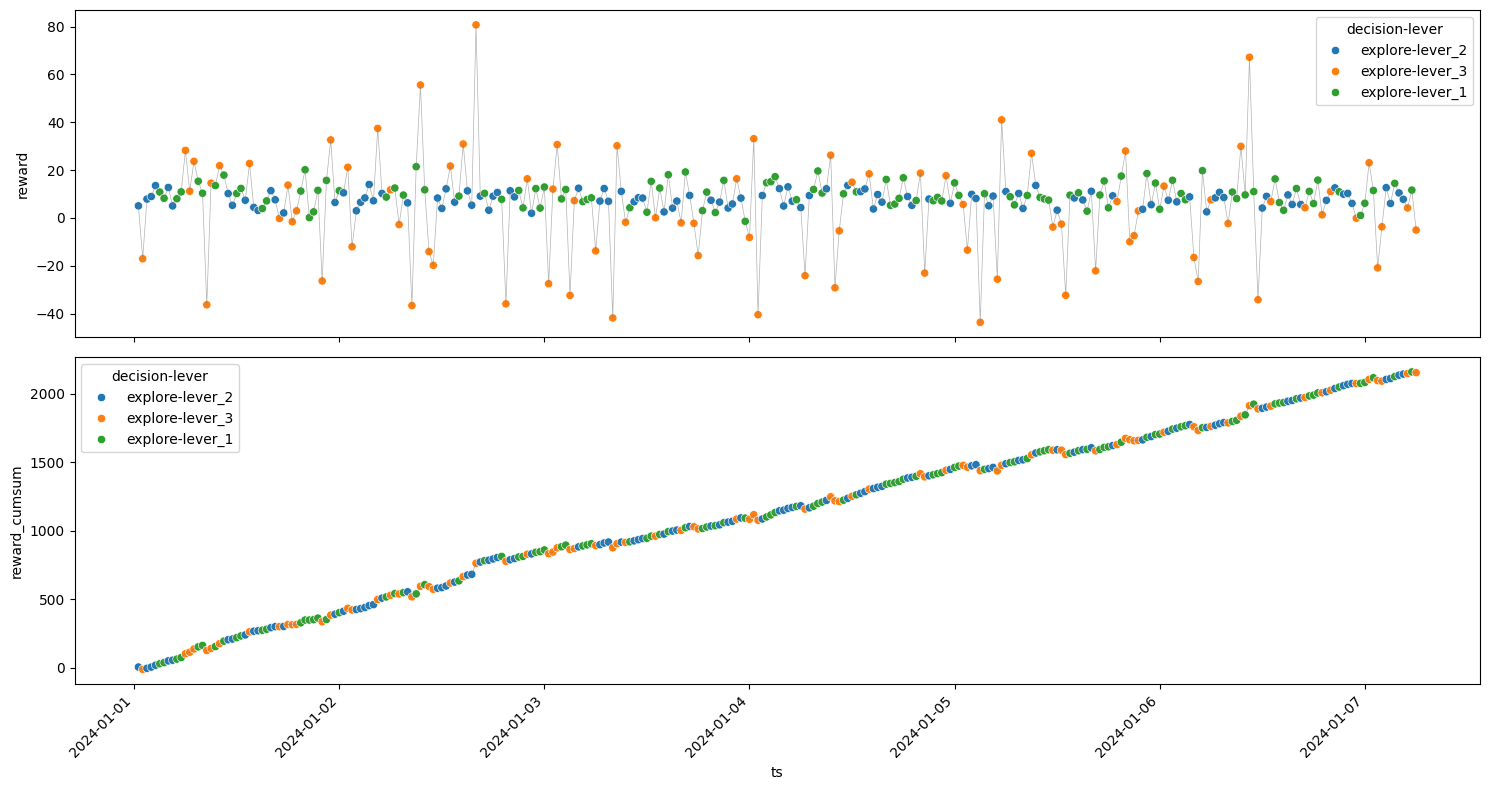

In [12]:
get_regret(explore_aggdf, n_iterations=300)
plot_reward(explore_rewarddf)
explore_aggdf

### Sequential


    Optimum Reward  : 2973.1662628833587
    Total Reward    : 2067.096791312746 
    Regret          : 906.0694715706127
    


lever decision reward                                              \
                     count         sum        min        max      mean   
0  lever_1  explore    100  991.055421  -2.022458  21.367141  9.910554   
1  lever_2  explore    100  752.399666   0.268610  18.515731  7.523997   
2  lever_3  explore    100  323.641704 -57.451587  96.641842  3.236417   

              
         std  
0   5.317706  
1   3.118744  
2  27.939732

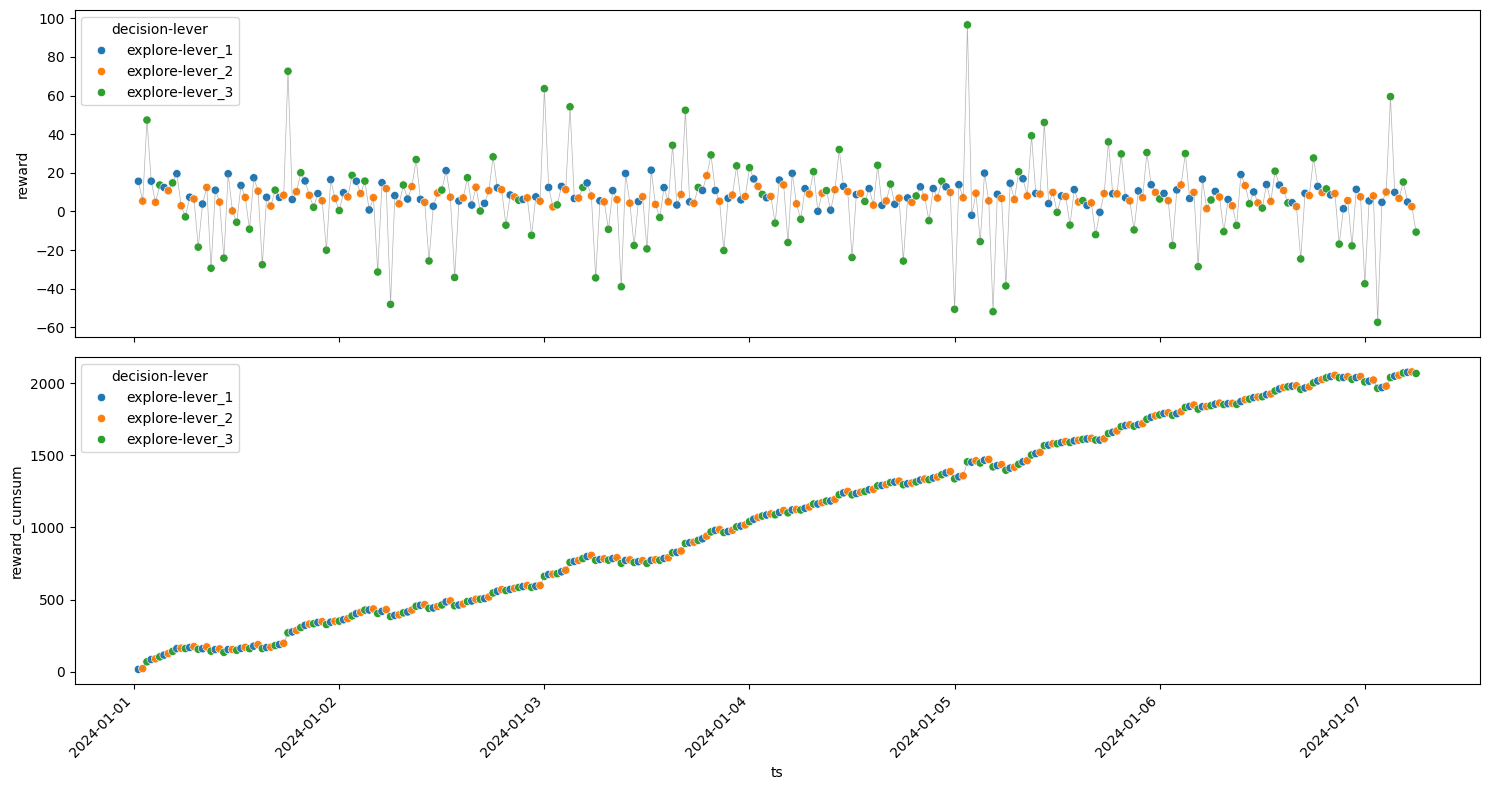

In [13]:
levers_iterator = levers_cyclic_iter(levers)
model = Model(levers)

for _ in range(300):
    model.explore(next(levers_iterator))

explore_rewarddf = model.rewardsdf
explore_aggdf, _ = get_metrics(explore_rewarddf)

get_regret(explore_aggdf, n_iterations=300)
plot_reward(explore_rewarddf)
explore_aggdf

## Only Exploitation



    Optimum Reward  : 3386.1053242326852
    Total Reward    : 2967.711848549018 
    Regret          : 418.393475683667
    


lever decision reward                                                \
                     count          sum        min        max       mean   
0  lever_1  exploit    297  2969.057393  -9.409683  26.911162   9.996826   
1  lever_1  explore      1    11.287018  11.287018  11.287018  11.287018   
2  lever_2  explore      1     4.018535   4.018535   4.018535   4.018535   
3  lever_3  explore      1   -16.651097 -16.651097 -16.651097 -16.651097   

             
        std  
0  5.185255  
1       NaN  
2       NaN  
3       NaN

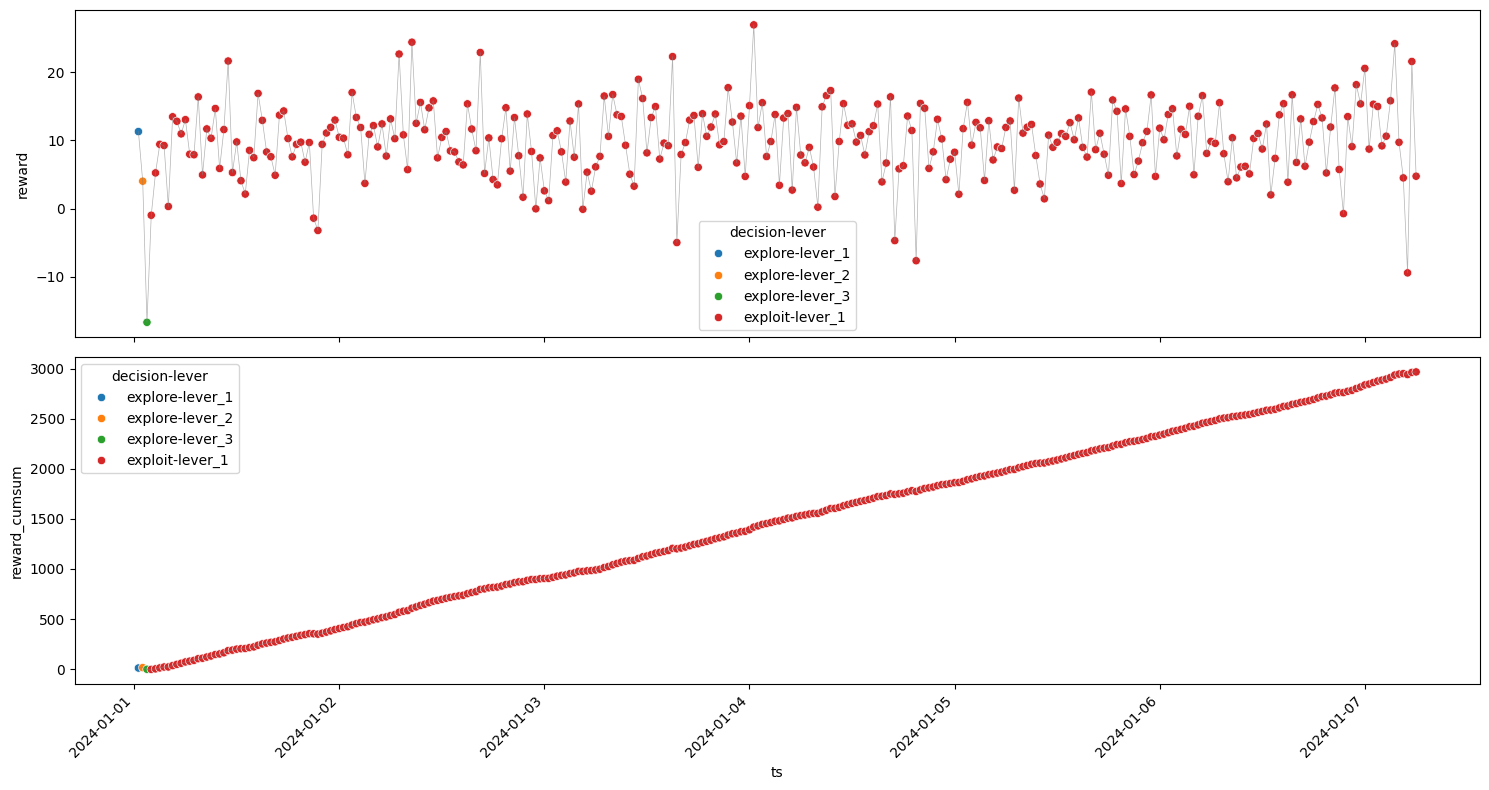

In [14]:
levers_iterator = levers_cyclic_iter(levers)

model = Model(levers)

for _ in range(3):
    model.explore(next(levers_iterator))

for i in range(297):
    model.exploit()

exploit_rewarddf =  model.rewardsdf
exploit_aggdf, _ = get_metrics(exploit_rewarddf)


get_regret(
    exploit_aggdf, n_iterations=300
)
plot_reward(exploit_rewarddf)
exploit_aggdf



    Optimum Reward  : 4376.431652988804
    Total Reward    : 2964.7402001010255 
    Regret          : 1411.6914528877783
    


lever decision reward                                                \
                     count          sum        min        max       mean   
0  lever_1  exploit    297  2977.659404  -1.439387  30.081474  10.025789   
1  lever_1  explore      1    14.588106  14.588106  14.588106  14.588106   
2  lever_2  explore      1     3.297641   3.297641   3.297641   3.297641   
3  lever_3  explore      1   -30.804951 -30.804951 -30.804951 -30.804951   

             
        std  
0  4.699891  
1       NaN  
2       NaN  
3       NaN

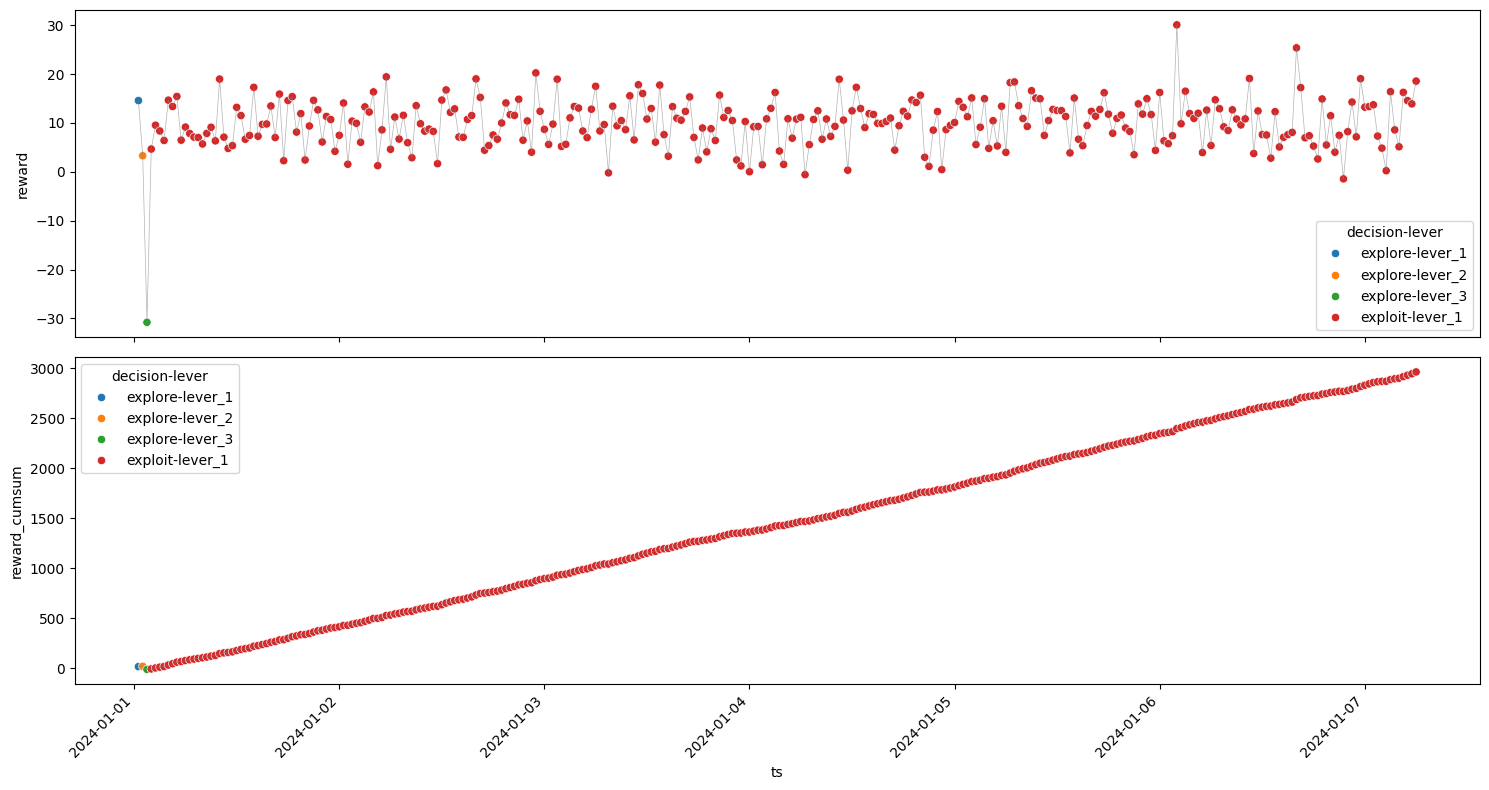

In [15]:
model = Model(levers)

for _ in range(3):
    model.explore(next(levers_iterator))
    
model.chosen_lever = "lever_1"

for i in range(297):
    model.exploit()

exploit_rewarddf =  model.rewardsdf
exploit_aggdf, _ = get_metrics(exploit_rewarddf)


get_regret(
    exploit_aggdf, n_iterations=300
)
plot_reward(exploit_rewarddf)
exploit_aggdf



    Optimum Reward  : 10849.961796829972
    Total Reward    : 2404.4283298665136 
    Regret          : 8445.533466963458
    


lever decision reward                                                \
                     count          sum        min        max       mean   
0  lever_1  explore      1     3.523400   3.523400   3.523400   3.523400   
1  lever_2  exploit    297  2354.245376  -2.365031  14.046799   7.926752   
2  lever_2  explore      1    10.493014  10.493014  10.493014  10.493014   
3  lever_3  explore      1    36.166539  36.166539  36.166539  36.166539   

             
        std  
0       NaN  
1  2.775326  
2       NaN  
3       NaN

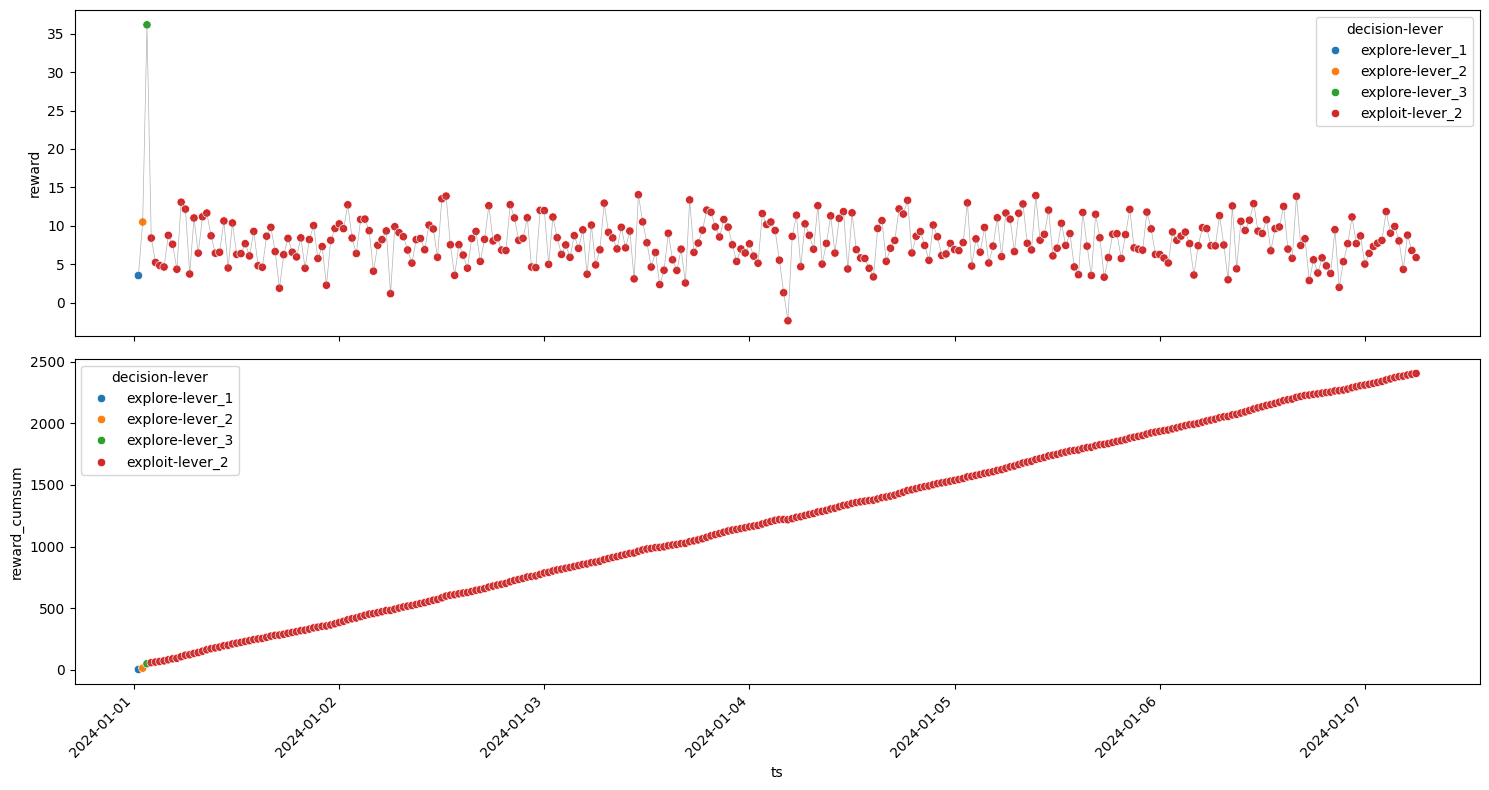

In [16]:
model = Model(levers)

for _ in range(3):
    model.explore(next(levers_iterator))
    
model.chosen_lever = "lever_2"

for i in range(297):
    model.exploit()

exploit_rewarddf =  model.rewardsdf
exploit_aggdf, _ = get_metrics(exploit_rewarddf)


get_regret(
    exploit_aggdf, n_iterations=300
)
plot_reward(exploit_rewarddf)
exploit_aggdf



    Optimum Reward  : 4620.554522293829
    Total Reward    : 1089.658454999903 
    Regret          : 3530.896067293926
    


lever decision reward                                                \
                     count          sum        min        max       mean   
0  lever_1  explore      1     4.370010   4.370010   4.370010   4.370010   
1  lever_2  explore      1    15.401848  15.401848  15.401848  15.401848   
2  lever_3  exploit    297  1063.742691 -70.830403  74.422912   3.581625   
3  lever_3  explore      1     6.143906   6.143906   6.143906   6.143906   

              
         std  
0        NaN  
1        NaN  
2  26.643151  
3        NaN

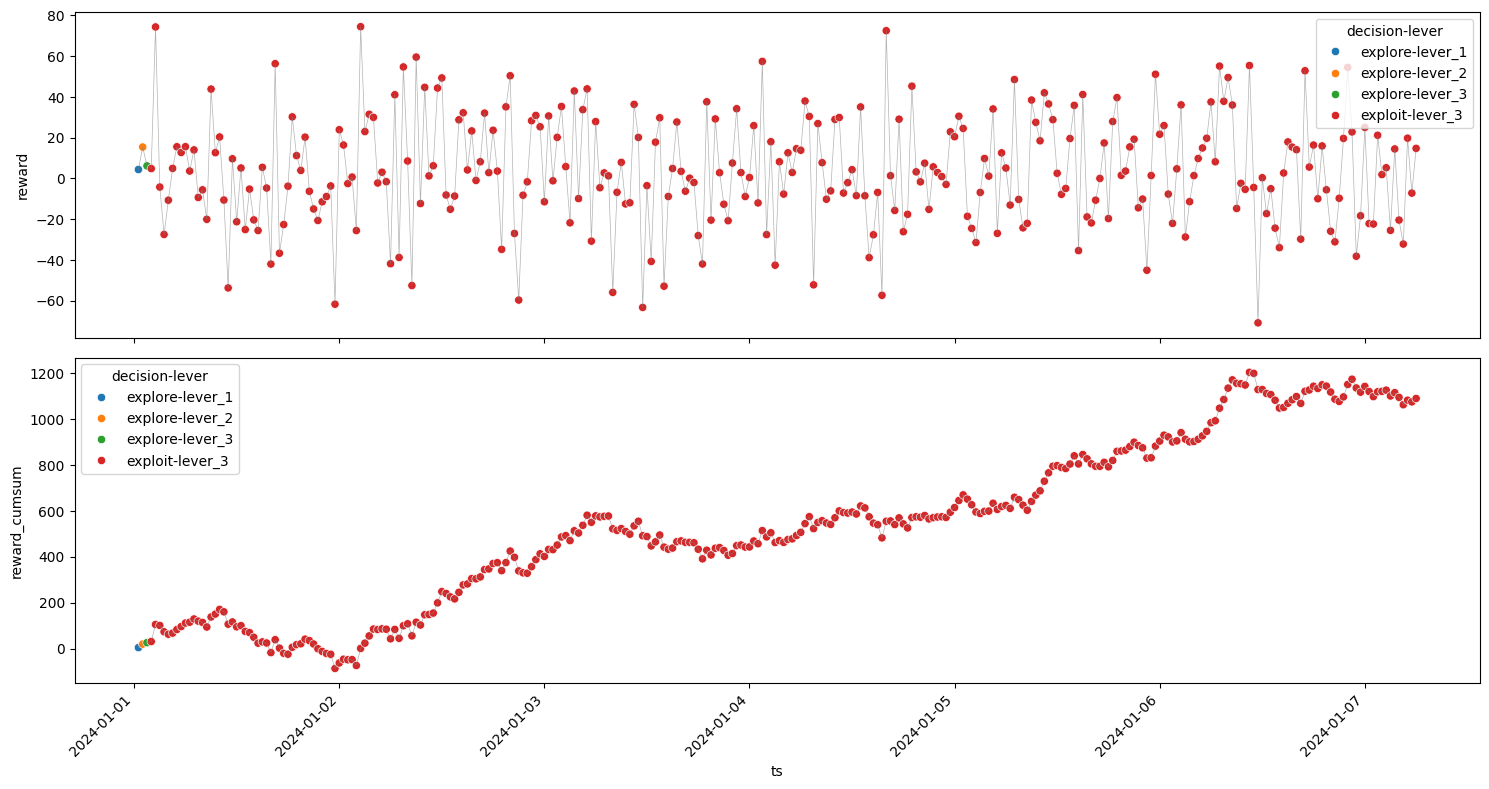

In [17]:
model = Model(levers)

for _ in range(3):
    model.explore(next(levers_iterator))
    
model.chosen_lever = "lever_3"

for i in range(297):
    model.exploit()

exploit_rewarddf =  model.rewardsdf
exploit_aggdf, _ = get_metrics(exploit_rewarddf)


get_regret(
    exploit_aggdf, n_iterations=300
)
plot_reward(exploit_rewarddf)
exploit_aggdf

## Alternative Sequentially Exploration & Exploitation


In [18]:
def explore_exploit(
    n_iterations=300,
    explore_iters=10,
    exploit_iters=10,
    levers=levers,
):

    model = Model(levers)
    run_explore = True

    explore_counter, exploit_counter = 0, 0

    for i in range(n_iterations):
        if run_explore:
            model.explore()
            explore_counter += 1
        else:
            model.exploit()
            exploit_counter += 1

        if explore_counter == explore_iters:
            run_explore = False
            explore_counter = 0

        if exploit_counter == exploit_iters:
            run_explore = True
            exploit_counter = 0

    return model


    Optimum Reward  : 3328.1668851982713
    Total Reward    : 2745.5535205865626 
    Regret          : 582.6133646117087
    


lever decision reward                                               \
                     count         sum        min        max       mean   
0  lever_1  exploit     80  735.756167  -2.234763  19.120568   9.196952   
1  lever_1  explore     54  599.070039   2.437164  24.093042  11.093890   
2  lever_2  explore     44  336.214502   1.113927  13.812017   7.641239   
3  lever_3  exploit     70  700.715816 -53.358556  64.040121  10.010226   
4  lever_3  explore     52  373.796996 -41.628942  59.210997   7.188404   

              
         std  
0   5.040052  
1   5.355777  
2   3.112142  
3  25.010759  
4  24.111241

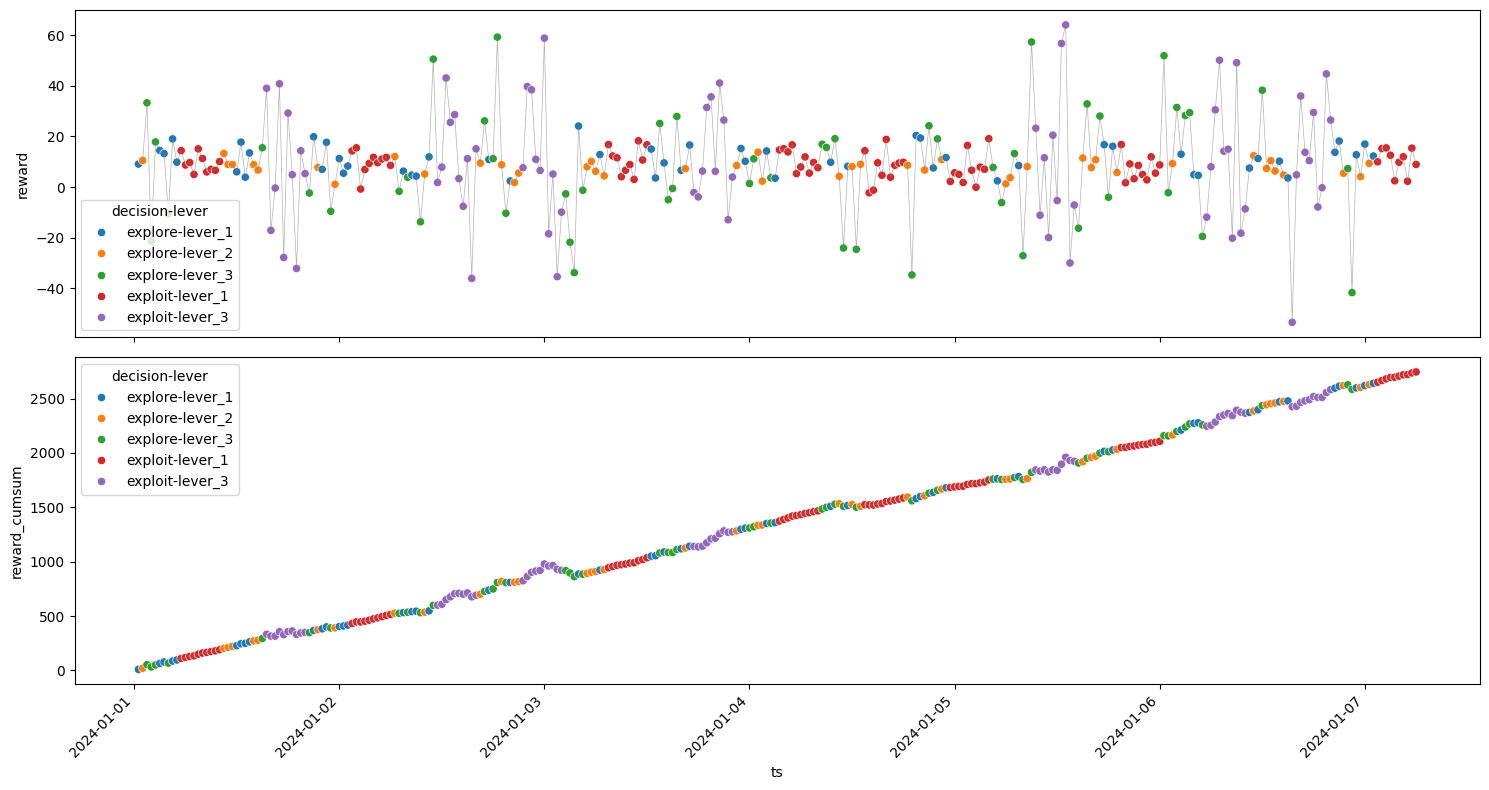

In [19]:
model = explore_exploit(
    n_iterations=300,
    explore_iters=10,
    exploit_iters=10,
    levers=["lever_1", "lever_2", "lever_3"],
)
experiment_rewarddf =  model.rewardsdf
experiment_aggdf, _ = get_metrics(experiment_rewarddf)

plot_reward(experiment_rewarddf)

get_regret(experiment_aggdf, n_iterations=300)

experiment_aggdf



    Optimum Reward  : 2997.2636794187392
    Total Reward    : 2190.662955589859 
    Regret          : 806.6007238288803
    


lever decision reward                                              \
                     count         sum        min        max      mean   
0  lever_1  exploit     50  472.293651  -5.037359  20.336700  9.445873   
1  lever_1  explore     35  349.680763   1.912881  21.779399  9.990879   
2  lever_2  exploit     80  651.297401   0.720124  14.120982  8.141218   
3  lever_2  explore     34  262.390396   0.315343  14.338983  7.717365   
4  lever_3  exploit     70  327.386653 -53.248427  64.981647  4.676952   
5  lever_3  explore     31  127.614092 -42.923538  49.800063  4.116584   

              
         std  
0   5.682971  
1   5.250198  
2   3.008991  
3   2.984583  
4  28.486746  
5  26.829228

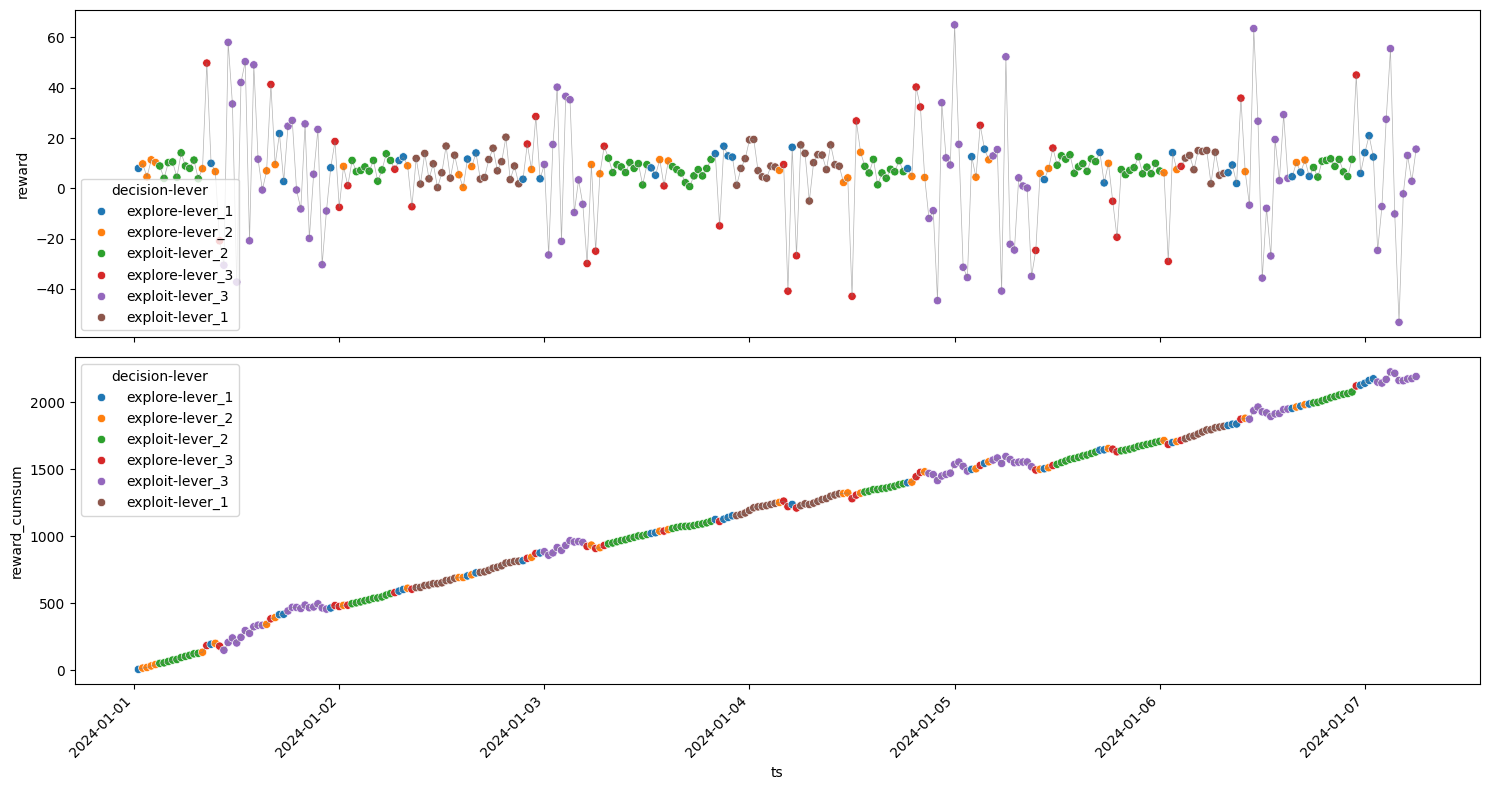

In [20]:
model = explore_exploit(
    n_iterations=300,
    explore_iters=5,
    exploit_iters=10,
    levers=levers,
)
experiment_rewarddf =  model.rewardsdf
experiment_aggdf, _ = get_metrics(experiment_rewarddf)

plot_reward(experiment_rewarddf)

get_regret(experiment_aggdf, n_iterations=300)

experiment_aggdf
